In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision
import glob
from PIL import Image
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import numpy as np
import random
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
from torch.distributions.multivariate_normal import MultivariateNormal
sys.path.insert(0, '/content/drive/MyDrive/Image_Synthesis')
import resnet
# from robustness import datasets

In [ ]:
DATA_SHAPE=224
GRAIN=4
BATCH_SIZE = 5

In [ ]:
# map imagenet to classes
class_name = {
    'tench': 'n01440764',
    'english springer': 'n02102040',
    'cassette player': 'n02979186',
    'chain saw': 'n03000684',
    'church': 'n03028079',
    'french horn': 'n03394916',
    'garbage truck': 'n03417042',
    'gas pump': 'n03425413',
    'golf ball': 'n03445777',
    'parachute': 'n03888257',  
}
# map imagenette to imagenet
class_ids = {0: 0,
              1: 217,
              2: 482,
              3: 491,
              4: 497,
              5: 566,
              6: 569,
              7: 571,
              8: 574,
              9: 701, }

imagenette_to_name = {0: 'tench',
                      1: 'english springer',
                      2: 'cassette player',
                      3: 'chain saw',
                      4: 'church',
                      5: 'french horn',
                      6: 'garbage truck',
                      7: 'gas pump',
                      8: 'golf ball',
                      9: 'parachute', }

In [ ]:
class InputNormalize(nn.Module):
    '''
    A module (custom layer) for normalizing the input to have a fixed 
    mean and standard deviation (user-specified).
    '''
    def __init__(self, new_mean, new_std):
        super(InputNormalize, self).__init__()
        new_std = new_std[..., None, None]
        new_mean = new_mean[..., None, None]

        self.register_buffer("new_mean", new_mean)
        self.register_buffer("new_std", new_std)

    def forward(self, x):
        x = torch.clamp(x, 0, 1)
        x_normalized = (x - self.new_mean)/self.new_std
        return x_normalized

In [ ]:
class ModelNormalizer(nn.Module):
    def __init__(self, model, normalizer):
        super(ModelNormalizer, self).__init__()
        self.normalizer = normalizer
        self.model = model
    
    def forward(self, input):
        return self.model(self.normalizer(input))

# layer we need to normalize the data
# The normalizer is the normalizer the robustness github uses in the helpers class
# For non robust model we are going to want to load Pytorch's resnet50 weights INTO the model we downloaded from github

In [ ]:
imagenet_pt = torch.load('/content/drive/MyDrive/Image_Synthesis/models/ImageNet.pt',
                         map_location=torch.device('cpu'))
imagenet_weights = imagenet_pt['model']
cleaned_model = {}
normalizer_fields = {}
for k,v in imagenet_weights.items():
    if k.startswith('module.model'):
        key = k[7:]
        cleaned_model[key] = v
    elif k.startswith('module.normalizer'):
        key = k[7:]
        cleaned_model[key] = v
        # print(key)
        # normalizer_fields[key] = v

# for k,v in cleaned_model.items():
#     print(k)

In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

input_Normalize = InputNormalize(mean, std)
mod_resnet_model = ModelNormalizer(resnet.resnet50(), input_Normalize)

In [ ]:
input_Normalize.new_mean.device

device(type='cpu')

In [ ]:
mod_resnet_model.load_state_dict(cleaned_model)
mod_resnet_model.cuda();
device = "cuda" if torch.cuda.is_available() else "cpu"
net = mod_resnet_model.to(device)
net.eval()


ModelNormalizer(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tru

In [ ]:
test_image_paths = []
classes=[]
test_data_path = '/content/drive/MyDrive/Image_Synthesis/imagenette2/mini'
for data_path in sorted(glob.glob(test_data_path + '/*')):
    classes.append(data_path.split('/')[-1])
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
class ImagenetteDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        # image = read_image(image_filepath)
        
        image = Image.open(image_filepath)
        image = image.convert("RGB")
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        # image = transforms.ToTensor()(image)
        
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
test_data = ImagenetteDataset(test_image_paths, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Feature batch shape: torch.Size([5, 3, 224, 224])
Labels batch shape: torch.Size([5])


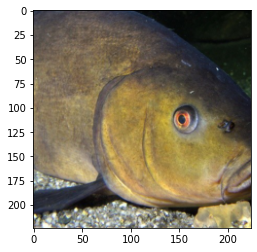

Label: 0


In [ ]:
test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = test_labels[0]
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [ ]:
PATCH_SIZE = 60

def mask_image(x, width=PATCH_SIZE):
    
    loc = np.random.randint(0, x.shape[-1] - width, size=(x.shape[0], 2))    
    mask = torch.zeros_like(x)
    for idx in range(x.shape[0]):
        i, j = loc[idx, 0], loc[idx, 1]
                                      #dim=2
        x_mean = torch.mean(x[idx, :], dim=2, keepdim=True)
        # print(type(x_mean), x_mean)
        val = torch.mean(x_mean, dim=1, keepdim=True)
        # Initialize masked region as mean pixel value over image (per channel)
        x[idx, :, i:i+width, j:j+width] = val.expand_as(x[idx, :, i:i+width, j:j+width])
        mask[idx, :, i:i+width, j:j+width] = 1
    return x, mask

<class 'torch.Tensor'>
torch.Size([5, 3, 224, 224])


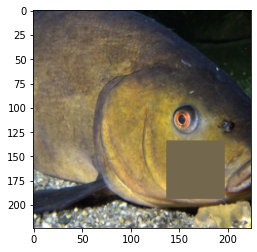

In [ ]:
# img_features, img_labels = next(iter(test_dataloader))
img_orig = test_features.type(torch.float32)
img_corrupt, mask = mask_image(img_orig.clone())
print(type(img_corrupt))
print(img_corrupt.shape)

first_img = img_corrupt[0].squeeze()
first_img = first_img.permute(1, 2, 0)
#first_img = first_img.type(torch.int64)
plt.imshow(first_img)
plt.show()

In [ ]:
# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(model,device,data,lbl, loss_list, num_im, mask, lmda, x_nat):
    dat = data.clone().detach()
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out,lbl) + (lmda * (((dat - x_nat) * (1 - mask))**2).mean())
    model.zero_grad()
    loss.backward()
    loss_list.append(loss.item()/num_im)
    data_grad = dat.grad.data
    return data_grad.data.detach(), loss_list

def PGD_attack(model, device, dat, lbl, eps, alpha, iters, rand_start, loss_list, iter_list, num_im, mask, lmda):
    # TODO: Implement the PGD attack
    # - dat and lbl are tensors
    # - eps and alpha are floats
    # - iters is an integer
    # - rand_start is a bool

    # x_nat is the natural (clean) data batch, we .clone().detach()
    # to copy it and detach it from our computational graph
    x_nat = dat.clone().detach()

    # If rand_start is True, add uniform noise to the sample within [-eps,+eps],
    # else just copy x_nat
    # if rand_start == True:
    #   x_nat_clone = x_nat + torch.FloatTensor(x_nat.shape).uniform_(-eps, eps).to(device)
    # else:
    #   x_nat_clone = x_nat

    # Make sure the sample is projected into original distribution bounds [0,1]
    x_nat_clone = torch.clamp(x_nat.clone().detach(), 0., 1.)
    # x_nat_clone = x_nat

    # Iterate over iters
    for iter in range(iters):
      iter_list.append(iter)

        # Compute gradient w.r.t. data (we give you this function, but understand it)
      gradient, loss_list = gradient_wrt_data(model, device, x_nat_clone, lbl, loss_list, num_im, mask, lmda, x_nat=x_nat)
      # gradient = generation_loss(model, x_nat_clone, lbl)
      # gradient_flatten = gradient.view(gradient.shape[0],-1)
      # l2_of_grad = torch.norm(gradient_flatten, p=2, dim=1)
      # l2_of_grad = torch.clamp(l2_of_grad, min=1e-12)
      # norm_grad = gradient/l2_of_grad
      l = len(x_nat.shape) - 1
      g_norm = torch.norm(gradient.view(gradient.shape[0], -1), dim=1).view(-1, *([1]*l))
      norm_grad = gradient / (g_norm + 1e-10)
        # Perturb the image using the gradient
      x_nat_clone = x_nat_clone - (alpha * norm_grad)
        # Clip the perturbed datapoints to ensure we still satisfy L_infinity constraint
                  #projection step
      diff = x_nat_clone - x_nat
      diff = diff.renorm(p=2, dim=0, maxnorm=eps)
      x_nat_clone = torch.clamp(x_nat.clone().detach() + diff.clone().detach(), 0., 1.)

        # Clip the perturbed datapoints to ensure we are in bounds [0,1]
      # x_nat_clone = torch.clamp(x_nat_clone.clone().detach(), 0, 1)

    # Return the final perturbed samples
    return x_nat_clone, loss_list, iter_list


In [ ]:
def inpainting_loss_wrapper(im_targ, mask, normalizer, lambdar=10):
    def inpainting_loss(mod, inp, targ):
        op = mod(normalizer(inp), fake_relu=True)
        loss = torch.nn.CrossEntropyLoss(reduction='none')(op, targ)
        loss_l2 = ((im_targ - inp) * (1 - mask) )**2
        loss_l2 = loss_l2.mean(-1).mean(-1).mean(-1)
        loss += lambdar * loss_l2
        return loss, None
    return inpainting_loss

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net = mod_resnet_model.to(device)
print(device)

cuda


In [ ]:
def get_axis(axarr, H, W, i, j):
    H, W = H - 1, W - 1
    if not (H or W):
        ax = axarr
    elif not (H and W):
        ax = axarr[max(i, j)]
    else:
        ax = axarr[i][j]
    return ax

def show_image_row(xlist, ylist=None, fontsize=12, size=(2.5, 2.5), tlist=None, filename=None):
    H, W = len(xlist), len(xlist[0])
    fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
    for w in range(W):
        for h in range(H):
            ax = get_axis(axarr, H, W, h, w)                
            ax.imshow(xlist[h][w].permute(1, 2, 0))
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            if ylist and w == 0: 
                ax.set_ylabel(ylist[h], fontsize=fontsize)
            if tlist:
                ax.set_title(tlist[h][w], fontsize=fontsize)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [ ]:
EPS = 21
ITS= 720
ALP = 0.1
num_im=5
lmda=10

for data,labels in test_dataloader:
        data = data.to(device); labels = labels.to(device)
        print(labels)
        target_to_imgnet=[]
        for t in labels:
          target_to_imgnet.append(class_ids[t.item()])
          target_class_adj = torch.tensor(target_to_imgnet)
        target_class_adj = target_class_adj.to(device)
        img_corrupt, mask = mask_image(data.clone())
        loss_list=[]
        iter_list=[]

        ###
        # Compute and apply adversarial perturbation to data
        adv_data, loss_list, iter_list = PGD_attack(model=net, device=device, dat=img_corrupt, 
                              lbl=target_class_adj.long(), eps=EPS, alpha=ALP, iters=ITS, rand_start=False, loss_list=loss_list, iter_list=iter_list, num_im=num_im, mask=mask, lmda=lmda)

        show_image_row([img_corrupt.cpu(), data.cpu(), adv_data.detach().cpu()], 
               ["Corrupted", "Original", "Inpainted"],
               fontsize=22)
        plt.plot(iter_list, loss_list)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss for {}'.format(imagenette_to_name[int(t)]))
        plt.show()

Output hidden; open in https://colab.research.google.com to view.